In [1]:
from typing import Dict, Union

#model_general
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.data import Data
from torch_cluster import radius_graph
from torch_scatter import scatter
import torch_scatter

#e3nn
import e3nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import FullyConnectedNet, Gate
#from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from e3nn.util.jit import compile_mode

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from ase import io

#other
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import math
import time
from tqdm import tqdm
import numpy as np
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
textsize = 14
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [2]:
from _GraphNW import PeriodicNetwork, Network
import _Convolution
from _Training import train, evaluate
from Data_processing import data_processing, get_neighbors
from Split_dat import split

100%|██████████| 118/118 [00:00<00:00, 214905.72it/s]


In [6]:
r_max = 4
data, y_m, y_std = data_processing('input.xyz', r_max)

In [11]:
d_load_train, d_load_val, d_load_test = split(data, train_size=0.8, valid_size=0.1, test_size=0.1)

In [12]:
n_train = get_neighbors(d_load_train.dataset)

In [6]:
out_dim = 1
em_dim = 64  

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=3,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean() #num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    #reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): Linear(64x0e -> 64x0e | 4096 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): Linear(64x0e+64x1o -> 64x0e+32x1o | 6144 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): Linear(32x0e+32x1o -> 32x0e+32x1o | 2048 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+32x1e | 160 paths | 160 weights)
        (lin2): Linear(64x0e+64x1o+32x1e -> 96x0e+32x1o+32x1e | 9216 weights)
      )
      (second): Gat

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

In [9]:
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
fontsize = 14

def plot_example(df, i=0, label_edges=False):
    # plot an example crystal structure and graph
    entry = df[i]

    # get graph with node and edge attributes
    g = tg.utils.to_networkx(entry, node_attrs=['symbol'], edge_attrs=['edge_len'], to_undirected=True)

    # remove self-loop edges for plotting
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    node_labels = dict(zip([k[0] for k in g.nodes.data()], [k[1]['symbol'] for k in g.nodes.data()]))
    edge_labels = dict(zip([(k[0], k[1]) for k in g.edges.data()], [k[2]['edge_len'] for k in g.edges.data()]))

    # project positions of nodes to 2D for plotting
    pos = dict(zip(list(g.nodes), [np.roll(k,2)[:-1][::-1] for k in entry.pos.numpy()]))

    # plot unit cell
    fig, ax = plt.subplots(1,2, figsize=(18,14), gridspec_kw={'width_ratios': [2,3]})
    atoms = Atoms(symbols=entry.symbol, positions=entry.pos.numpy(), cell=entry.lattice.squeeze().numpy(), pbc=True)
    symbols = np.unique(entry.symbol)
    z = dict(zip(symbols, range(len(symbols))))
    norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
    color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in entry.symbol]))]
    plot_atoms(atoms, ax[0], radii=0.25, colors=color, rotation=('45x,45y,0z'))

    # plot graph
    nx.draw_networkx(g, ax=ax[1], labels=node_labels, pos=pos, node_size=200, node_color=color,
                     edge_color='gray')
    
    if label_edges:
        nx.draw_networkx_edge_labels(g, ax=ax[1], edge_labels=edge_labels, pos=pos, label_pos=0.5)
    
    # format axes
    ax[0].set_xlabel(r'$x_1\ (\AA)$')
    ax[0].set_ylabel(r'$x_2\ (\AA)$')
    ax[0].set_title('Crystal structure', fontsize=fontsize)
    ax[1].set_aspect('equal')
    ax[1].axis('off')
    ax[1].set_title('Crystal graph', fontsize=fontsize)
    pad = np.array([-0.5, 0.5])
    ax[1].set_xlim(np.array(ax[1].get_xlim()) + pad)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) + pad)
    fig.subplots_adjust(wspace=0.4)

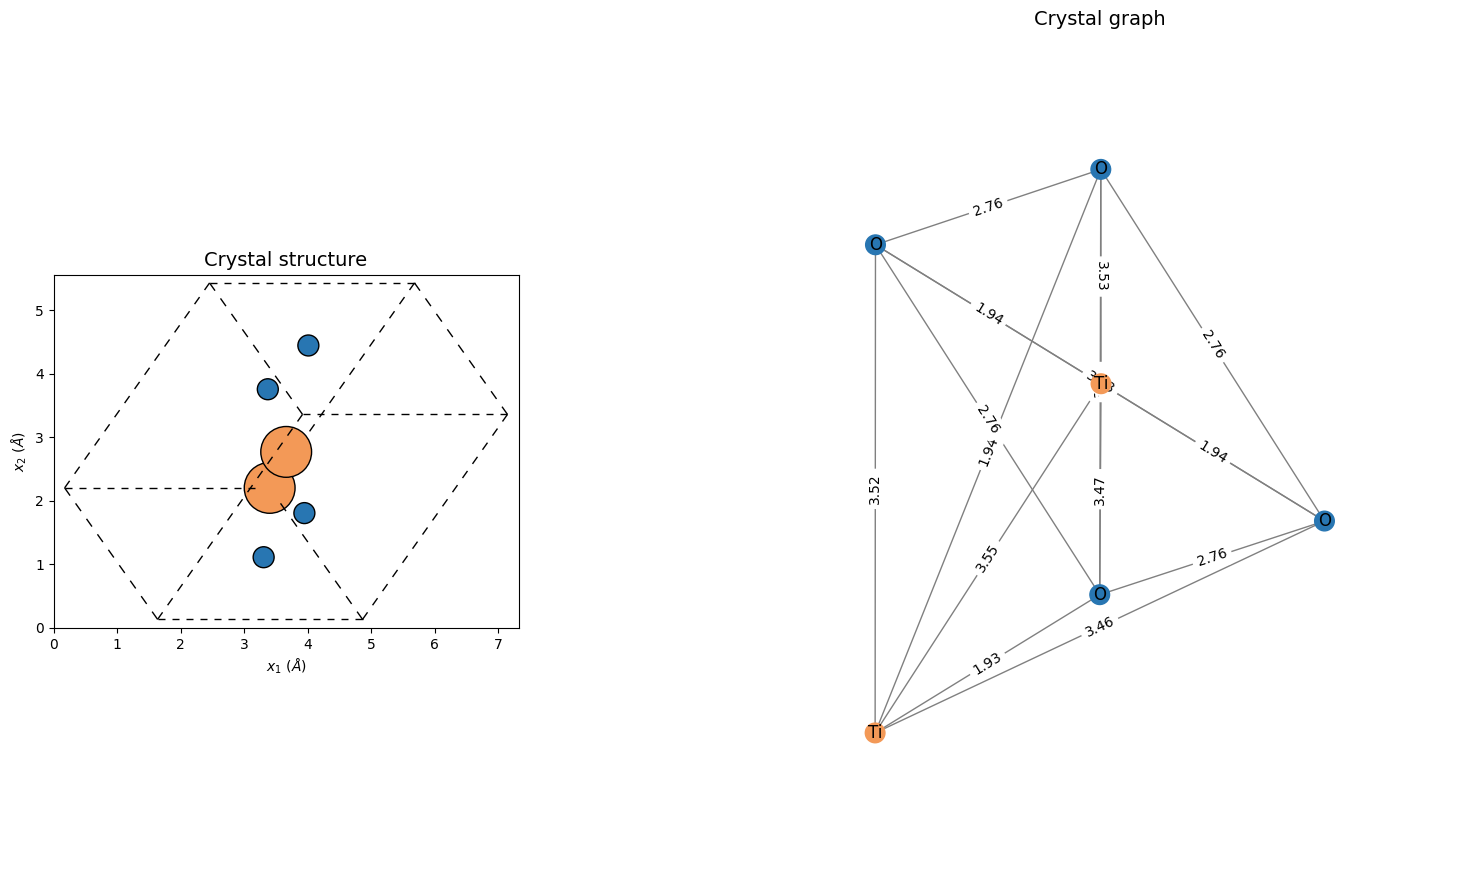

In [14]:
plot_example(data, 0, label_edges=True)

In [7]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
print(run_name)

torch device: cpu
model_241027


In [9]:
train(model, opt, d_load_train, d_load_val, loss_fn, loss_fn_mae, run_name,
      max_iter=3, scheduler=scheduler, device=device)

/Users/dndung/Desktop/MEGNET/NequIP/Simp_nequip/_Training.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  try: model.load_state_dict(torch.load(run_name + '.torch')['st

Iteration    1   train loss =   0.1493   valid loss =   0.1330   elapsed time = 00:00:14


100%|██████████| 960/960 [00:14<00:00, 65.12it/s]


Iteration    2   train loss =   0.0277   valid loss =   0.0264   elapsed time = 00:00:33


100%|██████████| 960/960 [00:14<00:00, 66.21it/s]


Iteration    3   train loss =   0.0167   valid loss =   0.0147   elapsed time = 00:00:52


/var/folders/mp/45b1mfk91r197n5vmxp2jvmw0000gn/T/ipykernel_1505/1673813701.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(run_name + '.torch', map_

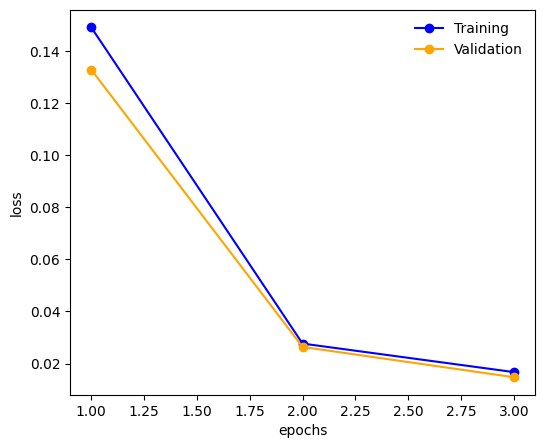

In [18]:
run_name = 'model_241026'

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color='blue')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='orange')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

In [11]:
#force
#class

def force(data):
    #data = data.clone()
    
    def wrapper(pos: torch.Tensor) -> torch.Tensor:
        #nonlocal data
        #_data = data#.clone()
        #_data.pos = pos
        #data.pos = pos
        #_, out = model(_data)
        #out, _ = model(data)
        out = data.pos[0]
        #out = out*torch.tensor(y_std) + torch.tensor(y_m)
        print(pos)
        return out#.squeeze(-1)
        
    pos = data.pos
    pos.requires_grad = True
    
    f = torch.autograd.functional.jacobian(
            func=wrapper,
            inputs=pos,
            create_graph=True,  # needed to allow gradients of this output during training
            #vectorize=self.vectorize,
        )
    #print(pos)
    return f

In [12]:
d = data[1].clone()
d.pos

tensor([[2.2822, 2.2835, 1.4572],
        [4.5595, 4.5614, 0.0095],
        [0.8906, 3.6724, 1.4587],
        [3.6638, 0.8974, 1.4684],
        [1.3830, 1.3834, 2.9245],
        [3.1797, 3.1864, 0.0089]])

In [13]:
force(d)

tensor([[2.2822, 2.2835, 1.4572],
        [4.5595, 4.5614, 0.0095],
        [0.8906, 3.6724, 1.4587],
        [3.6638, 0.8974, 1.4684],
        [1.3830, 1.3834, 2.9245],
        [3.1797, 3.1864, 0.0089]], grad_fn=<ViewBackward0>)


tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [26]:
data[1]

Data(x=[6, 118], edge_index=[2, 140], pos=[6, 3], lattice=[1, 3, 3], symbol=[6], z=[6, 118], edge_shift=[140, 3], edge_vec=[140, 3], edge_len=[140], energy=[1])

In [ ]:
import copy
pred = []
ref = []
dat = copy.deepcopy(data)
for i, d in enumerate(dat):
    pred.append(model(d).detach().numpy()*y_std + y_m)
    ref.append(d.energy.detach().numpy()*y_std + y_m)

plt.xlim(-58.64, -58.59)
plt.ylim(-58.64, -58.59)
plt.scatter(pred, ref)